In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import datetime
import sqlite3
import os

# import xgboost
import xgboost as xgb
from xgboost import XGBClassifier

# Loading modelling algorithms
# Załadowanie algorytmów modeli
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neighbors    import KNeighborsRegressor
from sklearn.ensemble     import AdaBoostRegressor
from sklearn.ensemble     import RandomForestRegressor

# Loading tools
# Załadownie narzędzi
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler
from sklearn.metrics         import r2_score

# Ignore warning messages
# Ignorowanie ostrzeżeń
import warnings
warnings.filterwarnings('ignore')

In [78]:
# Destination folder (comment unused directory)
# Wybranie folderu docelowego
#1 
#os.chdir("C:/Users/Lukasz/Documents/GitHub/Analysis-and-forecast-of-stock-exchange-price-based-on-selected-indicators-using-machine-learning/data")
#2
os.chdir("F:/GitHub/Analysis-and-forecast-of-stock-exchange-price-based-on-selected-indicators-using-machine-learning/data")

# Creating a connection
# Stworzenie połączenia za pomocą sqlite3
conn = sqlite3.connect('predictions.db')
c = conn.cursor()

In [79]:
indicator='Peabody'
# Get SQLLite select statement for SP500 index and indicators
# Wybranie z bazy danych histotycznych wartosci akcji danej firmy oraz wskaźników
df = pd.read_sql_query("""select x."Date", c19."Index" Covid19, co."Index" as Crude_Oil, 
cr."Index" as Copper, s."Index" as Silver, p."Index" as Platinum,
ip."Index" as Industrial_Production, pa."Index" as Palladium, x."Index" as """+indicator+"""
 from """+indicator+""" as x
  LEFT OUTER JOIN Covid19 as c19 ON x.Date = C19.Date
  LEFT OUTER JOIN Crude_Oil as co ON x.Date=co.Date
  LEFT OUTER JOIN Copper as cr ON x.Date=cr.Date
  LEFT OUTER JOIN Silver as s ON x.Date=s.Date
  LEFT OUTER JOIN Platinum as p ON x.Date=p.Date
  LEFT OUTER JOIN Industrial_Prod as ip ON strftime('%Y-%m', x.Date)=strftime('%Y-%m', ip.Date)
  LEFT OUTER JOIN Palladium as pa ON x.Date=pa.Date
Where x."Index" and co."Index" and cr."Index" and s."Index" and p."Index"
and ip."Index" and pa."Index" IS NOT NULL
and x.Date < '2020-04-01'
""", conn)

# Delete date column
# Usunięcie kolumny "Date"
df = df.drop(columns=['Date'])

df.tail()

,Covid19,Crude_Oil,Copper,Silver,Platinum,Industrial_Production,Palladium,Peabody
730,416881.0,24.49,2.2040,13.965,745.50,103.664,2247.6,3.12
731,468092.0,22.60,2.1780,14.415,737.10,103.664,2226.1,2.84
732,527839.0,21.51,2.1720,14.315,740.82,103.664,2196.8,2.81
733,715377.0,20.09,2.1555,14.055,723.84,103.664,2197.6,2.70
734,777187.0,20.48,2.2280,13.930,728.80,103.664,2304.8,2.90


In [80]:
# Fillling with zeros NaN values
# Wstawienie 0 w miejscu NaN
df=df.fillna(0)

In [81]:
# Splitting data into features X, and labels y
# Podzielnie danych na X i y w celu zbudowania modelu predykcyjnego
X = df.drop(['Peabody'], axis=1)
y = df['Peabody']

In [82]:
# splitting data into train and test data
# Podzielnie danych na dane uczące i dane testowe
seed = 40
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size, 
                                                    random_state=seed)

In [83]:
# scaling values
# Przekształcenie wartości (Skalowanie polega na tym aby średnia wartość w danej kolumnie wynosiła 0, a średnie odychelnie 1)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train

array([[-0.164701  , -0.18981792,  0.64074855, ..., -0.48552946,
         0.77319112,  0.60569663],
       [-0.164701  ,  0.06016249,  0.55621165, ...,  0.3503954 ,
        -0.61831788, -0.69247543],
       [-0.164701  ,  1.07225132, -0.18066075, ..., -0.87055264,
         0.75572255, -0.88011386],
       ...,
       [-0.164701  , -0.43426779, -1.06219521, ...,  1.22731131,
        -1.65907652, -1.12434167],
       [-0.164701  ,  0.70834179,  1.85862231, ...,  1.54060014,
        -0.56958979, -0.54033937],
       [-0.164701  ,  1.41182648,  0.11770476, ..., -0.69926856,
         0.35440529, -0.80029307]])

In [84]:
# testing different algorithms to get the data predictions (for visualization in plot)
# Testowanie róznych algorytmów oraz stworzenie listy w celu porównania
scores = []
models = ['Linear Regression'
          , 'Ridge Regression'
          , 'AdaBoost Regression'
          , 'RandomForest Regression'
          , 'XGBoost'
         ]

# Budowanie modeli predykcyjnych

## Linear Regression

In [85]:
lr = LinearRegression()
lr.fit(X_train , y_train)
y_pred = lr.predict(X_test)
r2 = r2_score(y_test, y_pred)

In [86]:
# Appending the list with r2 score
# Dodanie do listy współczynnika determinacji R2
scores.append(r2)
print('Linear Regression R2: {0:.2f}'.format(r2))

Linear Regression R2: 0.89


# Ridge Regression

In [87]:
ridge = Ridge(normalize=True)
ridge.fit(X_train , y_train)
y_pred = ridge.predict(X_test)
r2 = r2_score(y_test, y_pred)

In [88]:
# Appending the list with r2 score
# Dodanie do listy współczynnika determinacji R2
scores.append(r2)
print('Ridge Regression R2: {0:.2f}'.format(r2))

Ridge Regression R2: 0.73


# Adaboost classifier

In [89]:
adaboost = AdaBoostRegressor(n_estimators=1000)
adaboost.fit(X_train , y_train)
y_pred = adaboost.predict(X_test)
r2 = r2_score(y_test, y_pred)

In [90]:
# Appending the list with r2 score
# Dodanie do listy współczynnika determinacji R2
scores.append(r2)
print('AdaBoost Regression R2: {0:.2f}'.format(r2))

AdaBoost Regression R2: 0.97


# Random forest

In [91]:
randomforest = RandomForestRegressor()
randomforest .fit(X_train , y_train)
y_pred = randomforest .predict(X_test)
r2 = r2_score(y_test, y_pred)

In [92]:
# Appending the list with r2 score
# Dodanie do listy współczynnika determinacji R2
scores.append(r2)
print('Random Forest R2: {0:.2f}'.format(r2))

Random Forest R2: 0.99


# XGBOOST

In [93]:
# Fit model no training data
# Dopasowanie modelu do danych uczących
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [94]:
# Make predictions for test data
# Stworzenie predykcji
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [95]:
# Evaluate predictions
# Oszacowanie współczynnika R2
r2 = r2_score(y_test, predictions)

In [96]:
# Appending the list with r2 score
# Dodanie do listy współczynnika determinacji R2
scores.append(r2)
print('XGBoost R2: {0:.2f}'.format(r2))

XGBoost R2: 0.90


# Machine Learning algorthims R2 score comparison

## Porównanie algorytmów uczenia maszynowego

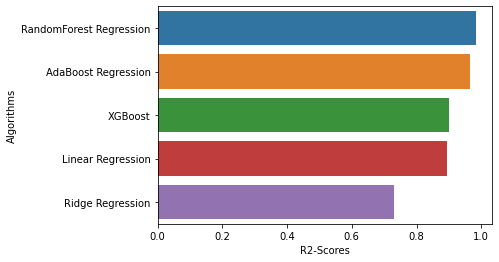

In [97]:
# Showing comparison on bar plot
# Przedstawienie porównania na wykresie słupkowym
ranking = pd.DataFrame({'Algorithms' : models , 'R2-Scores' : scores})
ranking = ranking.sort_values(by='R2-Scores' ,ascending=False)
ranking
 
sns.barplot(x='R2-Scores' , y='Algorithms' , data=ranking)